In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84131840/84125825 [==============================] - 171s 2us/step


In [5]:
os.listdir(dataset_dir)

['imdbEr.txt', 'test', 'imdb.vocab', 'README', 'train']

In [6]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_unsup.txt',
 'neg',
 'urls_pos.txt',
 'unsup',
 'urls_neg.txt',
 'pos',
 'unsupBow.feat',
 'labeledBow.feat']

In [7]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [8]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [9]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [21]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("---"*45)
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])
    print("Class Names", raw_train_ds.class_names[label_batch.numpy()[i]])

---------------------------------------------------------------------------------------------------------------------------------------
Review b'If you want Scream or anything like the big-studio horror product that we get forced on us these days don\'t bother. This well-written film kept me up thinking about all it had to say. Importance of myth in our lives to make it make sense, how children interpret the world (and the violence in it), our ransacking of the environment and ignorance of its history and legends.. all here, but not flatly on the surface. You could technically call it a "monster movie" even though the Wendigo does not take physical form until the end, and then it\'s even up to you and your beliefs as to what\'s happening with the legendary spirit/beast. Some standard thriller elements for those looking just for the basics and the film never bores, though in fact the less you see of the creature, the better. Fessenden successfully continues George Romero\'s tradition of

In [20]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [22]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [23]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


In [24]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [25]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Note: it's important to only use your training data when calling adapt (using the test set would leak information).


In [26]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [6]:
# Strip leading and trailing 2 elements
foo = tf.constant([1,2,3,4,5,6])
print(foo[2:-2].numpy())  # => [3,4]

# Skip every other row and reverse the order of the columns
foo = tf.constant([[1,2,3], [4,5,6], [7,8,9]])
print(foo[::2,::-1].numpy())  # => [[3,2,1], [9,8,7]]

# Use scalar tensors as indices on both dimensions
print(foo[tf.constant(0), tf.constant(2)].numpy())  # => 3

# Insert another dimension
foo = tf.constant([[1,2,3], [4,5,6], [7,8,9]])
print(foo[tf.newaxis, :, :].numpy()) # => [[[1,2,3], [4,5,6], [7,8,9]]]
print(foo[:, tf.newaxis, :].numpy()) # => [[[1,2,3]], [[4,5,6]], [[7,8,9]]]
print(foo[:, :, tf.newaxis].numpy()) # => [[[1],[2],[3]], [[4],[5],[6]],
[[7],[8],[9]]]

# Ellipses (3 equivalent operations)
foo = tf.constant([[1,2,3], [4,5,6], [7,8,9]])
print(foo[tf.newaxis, :, :].numpy())  # => [[[1,2,3], [4,5,6], [7,8,9]]]
print(foo[tf.newaxis, ...].numpy())  # => [[[1,2,3], [4,5,6], [7,8,9]]]
print(foo[tf.newaxis].numpy())  # => [[[1,2,3], [4,5,6], [7,8,9]]]

# Masks
foo = tf.constant([[1,2,3], [4,5,6], [7,8,9]])
print(foo[foo > 2].numpy())  # => [3, 4, 5, 6, 7, 8, 9]

SyntaxError: unmatched ']' (<ipython-input-6-a09c2b10d0f3>, line 17)

In [27]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [28]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'"Emma" was a product of what might be called by the First Great Jane Austen Cycle of the mid-nineties, and it was recently shown on British television, doubtless because of the interest in the author created by the Second Great Jane Austen Cycle which started with "Pride and Prejudice" two years ago. We currently have in the cinemas the Austen biopic "Becoming Jane", and ITV have recently produced three TV movies based on Austen novels. These include "Northanger Abbey", the only one of the six major novels not to have been filmed previously, so the cycle should now be complete. No doubt, however, there will be more to come in the near future. (There is, after all, her juvenile "Love and Freindship" (sic), the short novella "Lady Susan", and someone, somewhere, has doubtless supplied endings to her two unfinished fragments "The Watsons" and "Sanditon". Then there are all those Austen sequels churned out by modern writers\xc2\x85\xc2\x85\xc2\x85).<br /><br />The main c

In [29]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [30]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [31]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [32]:
embedding_dim = 16

In [33]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [47]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [35]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 69s 111ms/step - loss: 0.6638 - binary_accuracy: 0.6945 - val_loss: 0.6138 - val_binary_accuracy: 0.7726
Epoch 2/10
625/625 [==============================] - 1s 2ms/step - loss: 0.5474 - binary_accuracy: 0.8034 - val_loss: 0.4968 - val_binary_accuracy: 0.8210
Epoch 3/10
625/625 [==============================] - 1s 2ms/step - loss: 0.4438 - binary_accuracy: 0.8461 - val_loss: 0.4192 - val_binary_accuracy: 0.8478
Epoch 4/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3771 - binary_accuracy: 0.8661 - val_loss: 0.3733 - val_binary_accuracy: 0.8614
Epoch 5/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3356 - binary_accuracy: 0.8790 - val_loss: 0.3447 - val_binary_accuracy: 0.8684
Epoch 6/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3039 - binary_accuracy: 0.8899 - val_loss: 0.3255 - val_binary_accuracy: 0.8714
Epoch 7/10
625/625 [==============================] - 1s 2ms/

In [36]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 113s 145ms/step - loss: 0.3103 - binary_accuracy: 0.8728
Loss:  0.31025052070617676
Accuracy:  0.8727999925613403


In [37]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

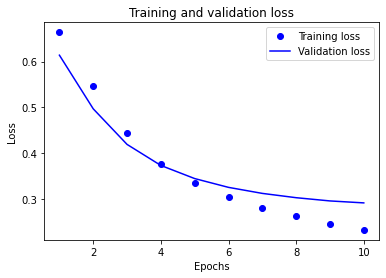

In [38]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

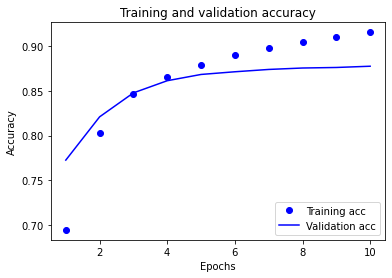

In [39]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [40]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 43s 56ms/step - loss: 0.3103 - accuracy: 0.8728
0.8727999925613403


In [41]:
export_model1 = tf.keras.Sequential()

In [42]:
export_model1.add(vectorize_layer)

In [43]:
export_model1.add(model)

In [44]:
export_model1.add(layers.Activation('sigmoid'))

In [45]:
export_model1.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

In [46]:
# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model1.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 54s 69ms/step - loss: 0.3103 - accuracy: 0.8728
0.8727999925613403
